# 📈 Change Point Detection

**Mục tiêu:** Phát hiện điểm gãy cấu trúc (Structural Break) trong dữ liệu điểm thi, tập trung vào năm 2025.

In [1]:
%pip install bayesian-changepoint-detection
# !pip install ruptures

Note: you may need to restart the kernel to use updated packages.


In [2]:
# --- CELL 1: SETUP HỆ THỐNG & IMPORT ---
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ruptures as rpt

# 1. Cấu hình đường dẫn để Python nhìn thấy thư mục 'Module' (nằm ở Project Root)
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    
# 2. Cấu hình để Python nhìn thấy file 'ChangePoint.py' (nằm cùng thư mục Notebook)
if current_dir not in sys.path:
    sys.path.append(current_dir)

print(f"Project Root: {project_root}")

# --- IMPORT MODULES ---
from Module.Load_Data import CleanDataLoader

# Import class chuẩn bị dữ liệu (Của Bạn)
from Module.ChangePointPreparer import ChangePointPreparer
from Module.ChangePointDetector import ChangePointDetector
from Module.ChangePointAnalyzer import ChangePointAnalyzer
# # Import class thuật toán (Của Nhóm Trưởng)
# try:
#     from Module.ChangePointDetector import ChangePointDetector
#     print("✅ Đã import thành công: ChangePointDetector")
# except ImportError:
#     print("⚠️ Cảnh báo: Không tìm thấy 'ChangePointDetector' trong folder Module. Hãy kiểm tra lại file của nhóm trưởng.")

Project Root: c:\Users\ADMIN\Documents\PythonProject


## 1. Chuẩn bị dữ liệu (Data Preparation)

In [3]:
# --- CELL 2: LẤY DỮ LIỆU TỪ CLEAN LOADER ---

# 1. Khởi tạo
preparer = ChangePointPreparer(clean_loader=CleanDataLoader())

# 2. Chọn đối tượng phân tích
# Môn học quan trọng
subjects_list = ["Toan", "Ngu_Van", "Ngoai_Ngu", "Vat_Li", "Lich_Su"]
# Khối thi quan trọng
blocks_list = ["A00", "A01", "B00", "C00"]
# Tỉnh thành lớn (Dùng tên không dấu viết liền theo quy ước)
provinces_list = ["HaNoi", "ThanhPhoHoChiMinh", "HaiPhong", "ĐaNang", "CanTho"]

# 3. Lấy chuỗi thời gian (Time Series)
print("⏳ Đang tải dữ liệu...")
df_subjects = preparer.get_subject_series(subjects_list, metric="mean")
df_blocks = preparer.get_block_series(blocks_list, metric="mean")
df_provinces = preparer.get_province_series(provinces_list, metric="mean")

print("\n--- Sample Data (Môn học) ---")
display(df_subjects)

print("\n--- Sample Data (Khối thi) ---")
display(df_blocks)

print("\n--- Sample Data (Tỉnh thành) ---")
display(df_provinces)

⏳ Đang tải dữ liệu...

--- Sample Data (Môn học) ---


,year,series_id,value
0,2023,Toan,6.250557
1,2024,Toan,6.447309
2,2025,Toan,4.799712
3,2023,Ngu_Van,6.858194
4,2024,Ngu_Van,7.231146
5,2025,Ngu_Van,6.990479
6,2023,Ngoai_Ngu,5.462410
7,2024,Ngoai_Ngu,5.521938
8,2025,Ngoai_Ngu,5.406338
9,2023,Vat_Li,6.573900



--- Sample Data (Khối thi) ---


,year,series_id,value
0,2023,A00,20.774499
1,2024,A00,20.904633
2,2025,A00,19.384368
3,2023,A01,20.275288
4,2024,A01,20.473793
5,2025,A01,18.878852
6,2023,B00,20.604733
7,2024,B00,20.531107
8,2025,B00,18.340640
9,2023,C00,18.974926



--- Sample Data (Tỉnh thành) ---


,year,series_id,value
0,2023,HaNoi,37.324483
1,2024,HaNoi,39.081294
2,2025,HaNoi,25.724696
3,2023,ThanhPhoHoChiMinh,38.174897
4,2024,ThanhPhoHoChiMinh,38.443969
5,2025,ThanhPhoHoChiMinh,25.010852
6,2023,HaiPhong,39.020116
7,2024,HaiPhong,40.876944
8,2025,HaiPhong,25.183939
9,2023,ĐaNang,35.831963


## 2. Phát hiện điểm gãy (Change Point Detection)
Sử dụng các thuật toán: **PELT** (Ruptures) và **CUSUM**.

In [4]:
# pip install ruptures

In [5]:
# --- CELL 3: CHẠY THUẬT TOÁN  ---

if 'ChangePointDetector' in globals():
    # 1. Khởi tạo bộ phát hiện (Giả thuyết điểm gãy là năm 2025, sai số 1 năm)
    # Chúng ta gộp cả 3 loại dữ liệu vào để chạy một thể cho hoành tráng
    full_data = pd.concat([df_subjects, df_blocks, df_provinces], ignore_index=True)
    
    detector = ChangePointDetector(full_data, target_year=2025, tolerance=1)

    # 2. Chạy PELT (Tinh chỉnh penalty=1 vì chuỗi ngắn 3 năm)
    print("\n▶️ Đang chạy thuật toán PELT...")
    df_pelt = detector.detect_ruptures(method="pelt", model="l2", pen=1)
    display(df_pelt)

    # 3. Chạy CUSUM
    print("\n▶️ Đang chạy thuật toán CUSUM...")
    df_cusum = detector.detect_cusum()
    display(df_cusum)
    
    # 4. Chạy Bayesian Online Change Point Detection (BOCPD)
    print("\n▶️ Đang chạy thuật toán BOCPD...")
    df_bayes = detector.detect_bayesian(probability_threshold=0.01)
    display(df_bayes)
    # 5. Tổng hợp kết quả (Những series nào thực sự gãy ở 2025?)
    print("\n🏆 --- KẾT QUẢ PHÁT HIỆN ĐIỂM GÃY (HIT TARGET 2025) ---")
    all_results = detector.analyze_all()
    hits = all_results[all_results['hit_target'] == True]
    display(hits)
else:
    print("❌ Không thể chạy thuật toán vì thiếu Module ChangePointDetector.")


▶️ Đang chạy thuật toán PELT...


,series_id,algorithm,detected_years,hit_target,hit_year,breakpoints
0,Toan,Ruptures_pelt_l2,[2025],True,2025,[3]
1,Ngu_Van,Ruptures_pelt_l2,[2025],True,2025,[3]
2,Ngoai_Ngu,Ruptures_pelt_l2,[2025],True,2025,[3]
3,Vat_Li,Ruptures_pelt_l2,[2025],True,2025,[3]
4,Lich_Su,Ruptures_pelt_l2,[2025],True,2025,[3]
5,A00,Ruptures_pelt_l2,[2025],True,2025,[3]
6,A01,Ruptures_pelt_l2,[2025],True,2025,[3]
7,B00,Ruptures_pelt_l2,[2025],True,2025,[3]
8,C00,Ruptures_pelt_l2,[2025],True,2025,[3]
9,HaNoi,Ruptures_pelt_l2,[2025],True,2025,[3]



▶️ Đang chạy thuật toán CUSUM...


,series_id,algorithm,detected_years,hit_target,hit_year,cusum_values
0,Toan,CUSUM_Mean,[2025],True,2025,"[0.5689714158646144, 1.4057366370051718, 0.0]"
1,Ngu_Van,CUSUM_Mean,[2024],True,2024,"[-1.0908581048172676, 0.23400756872605588, 1.1..."
2,Ngoai_Ngu,CUSUM_Mean,[2025],True,2025,"[-0.024397576094366533, 1.2123638149709473, 0.0]"
3,Vat_Li,CUSUM_Mean,[2025],True,2025,"[-0.9585514433456466, -1.3797668920043091, 1.0..."
4,Lich_Su,CUSUM_Mean,[2024],True,2024,"[-1.408158413813162, -0.5908652006821057, 7.21..."
5,A00,CUSUM_Mean,[2025],True,2025,"[0.6104272905789431, 1.4099914022104518, 1.043..."
6,A01,CUSUM_Mean,[2025],True,2025,"[0.562634073520074, 1.4049638560434103, -9.992..."
7,B00,CUSUM_Mean,[2025],True,2025,"[0.7418642137567919, 1.4136344211849636, 6.661..."
8,C00,CUSUM_Mean,[2024],True,2024,"[-1.1088879966200527, 0.20567149173998867, 1.3..."
9,HaNoi,CUSUM_Mean,[2025],True,2025,"[0.553675436844633, 1.4038171472390897, 1.1102..."



▶️ Đang chạy thuật toán BOCPD...
Use scipy logsumexp().
▶️ Đang chạy Bayesian Detection cho 14 chuỗi dữ liệu...
DEBUG Toan: Max Probs = 0.0971
DEBUG Ngu_Van: Max Probs = 0.0608
DEBUG Ngoai_Ngu: Max Probs = 0.0758
DEBUG Vat_Li: Max Probs = 0.0584
DEBUG Lich_Su: Max Probs = 0.0626
DEBUG A00: Max Probs = 0.0248
DEBUG A01: Max Probs = 0.0255
DEBUG B00: Max Probs = 0.0268
DEBUG C00: Max Probs = 0.0234
DEBUG HaNoi: Max Probs = 0.0221
DEBUG ThanhPhoHoChiMinh: Max Probs = 0.0231
DEBUG HaiPhong: Max Probs = 0.0234
DEBUG ĐaNang: Max Probs = 0.0251
DEBUG CanTho: Max Probs = 0.0234


,series_id,algorithm,detected_years,hit_target,hit_year,probs
0,Toan,Bayesian_Offline,[2024],True,2024,"[0.0, 0.09707427213623492]"
1,Ngu_Van,Bayesian_Offline,[2024],True,2024,"[0.0, 0.06083836259862393]"
2,Ngoai_Ngu,Bayesian_Offline,[2024],True,2024,"[0.0, 0.07575893103319754]"
3,Vat_Li,Bayesian_Offline,[2024],True,2024,"[0.0, 0.05840881500849693]"
4,Lich_Su,Bayesian_Offline,[2024],True,2024,"[0.0, 0.06264255591962975]"
5,A00,Bayesian_Offline,[2024],True,2024,"[0.0, 0.024789901210784254]"
6,A01,Bayesian_Offline,[2024],True,2024,"[0.0, 0.025481693916529297]"
7,B00,Bayesian_Offline,[2024],True,2024,"[0.0, 0.02675025738549715]"
8,C00,Bayesian_Offline,[2024],True,2024,"[0.0, 0.02339956514086999]"
9,HaNoi,Bayesian_Offline,[2024],True,2024,"[0.0, 0.022077020899422824]"



🏆 --- KẾT QUẢ PHÁT HIỆN ĐIỂM GÃY (HIT TARGET 2025) ---
▶️ Đang chạy Bayesian Detection cho 14 chuỗi dữ liệu...
DEBUG Toan: Max Probs = 0.0971
DEBUG Ngu_Van: Max Probs = 0.0608
DEBUG Ngoai_Ngu: Max Probs = 0.0758
DEBUG Vat_Li: Max Probs = 0.0584
DEBUG Lich_Su: Max Probs = 0.0626
DEBUG A00: Max Probs = 0.0248
DEBUG A01: Max Probs = 0.0255
DEBUG B00: Max Probs = 0.0268
DEBUG C00: Max Probs = 0.0234
DEBUG HaNoi: Max Probs = 0.0221
DEBUG ThanhPhoHoChiMinh: Max Probs = 0.0231
DEBUG HaiPhong: Max Probs = 0.0234
DEBUG ĐaNang: Max Probs = 0.0251
DEBUG CanTho: Max Probs = 0.0234


,series_id,algorithm,detected_years,hit_target,hit_year,breakpoints,cusum_values,probs
0,Toan,Ruptures_pelt_l2,[2025],True,2025,[3],NaN,NaN
1,Ngu_Van,Ruptures_pelt_l2,[2025],True,2025,[3],NaN,NaN
2,Ngoai_Ngu,Ruptures_pelt_l2,[2025],True,2025,[3],NaN,NaN
3,Vat_Li,Ruptures_pelt_l2,[2025],True,2025,[3],NaN,NaN
4,Lich_Su,Ruptures_pelt_l2,[2025],True,2025,[3],NaN,NaN
5,A00,Ruptures_pelt_l2,[2025],True,2025,[3],NaN,NaN
6,A01,Ruptures_pelt_l2,[2025],True,2025,[3],NaN,NaN
7,B00,Ruptures_pelt_l2,[2025],True,2025,[3],NaN,NaN
8,C00,Ruptures_pelt_l2,[2025],True,2025,[3],NaN,NaN
9,HaNoi,Ruptures_pelt_l2,[2025],True,2025,[3],NaN,NaN


## 3. Trực quan hóa (Visualization)
Vẽ biểu đồ minh họa sự thay đổi cấu trúc.

Đang vẽ biểu đồ nâng cao cho: Toan


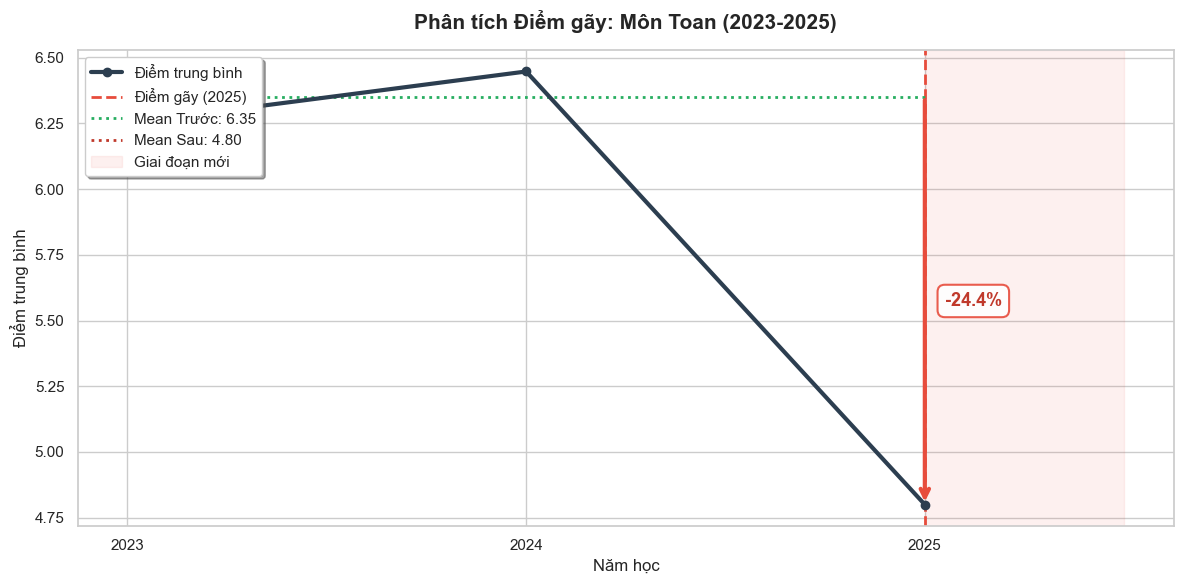

In [6]:
# --- CELL 4: VẼ BIỂU ĐỒ (PHIÊN BẢN GỠ LỖI) ---
# Giả sử detector đã chạy và có kết quả
if 'detector' in locals() and hasattr(detector, 'results'):
    # Lấy đại một kết quả có điểm gãy để vẽ demo
    # Ưu tiên lấy môn Toán hoặc Văn nếu có
    target_series = "Toan"
    row = detector.results[detector.results['series_id'] == target_series]
    
    if not row.empty and len(row.iloc[0]['detected_years']) > 0:
        years = row.iloc[0]['detected_years']
        print(f"Đang vẽ biểu đồ nâng cao cho: {target_series}")
        
        # GỌI HÀM MỚI TẠI ĐÂY
        detector.plot_enhanced(target_series, years)
    else:
        # Nếu Toán không gãy, lấy cái đầu tiên tìm được
        has_break = detector.results[detector.results['detected_years'].apply(len) > 0]
        if not has_break.empty:
            s_id = has_break.iloc[0]['series_id']
            yrs = has_break.iloc[0]['detected_years']
            detector.plot_enhanced(s_id, yrs)
        else:
            print("Chưa tìm thấy điểm gãy nào để vẽ.")


## 4. Phân tích điểm gãy (Change Point Analysis)

=== BẢNG TỔNG HỢP CHANGE POINT ===


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:4268: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,series_id,break_point,mean_pre,mean_post,delta_pct,p_value,significant,cohen_d,magnitude
0,Toan,2025,6.35,4.80,-24.40,0.0404,True,-11.14,Mạnh (Strong)
1,Ngu_Van,2025,7.04,6.99,-0.77,0.8200,False,-0.21,Yếu (Weak)
2,Ngoai_Ngu,2025,5.49,5.41,-1.56,0.2125,False,-2.04,Mạnh (Strong)
3,Vat_Li,2025,6.62,6.98,5.41,0.0822,False,5.45,Mạnh (Strong)
4,Lich_Su,2025,6.30,6.51,3.44,0.5718,False,0.56,Vừa (Medium)
5,Toan,2025,6.35,4.80,-24.40,0.0404,True,-11.14,Mạnh (Strong)
6,Ngu_Van,2024,6.86,7.11,3.68,NaN,False,0.00,Không đáng kể
7,Ngoai_Ngu,2025,5.49,5.41,-1.56,0.2125,False,-2.04,Mạnh (Strong)
8,Vat_Li,2025,6.62,6.98,5.41,0.0822,False,5.45,Mạnh (Strong)
9,Lich_Su,2024,6.03,6.54,8.58,NaN,False,0.00,Không đáng kể


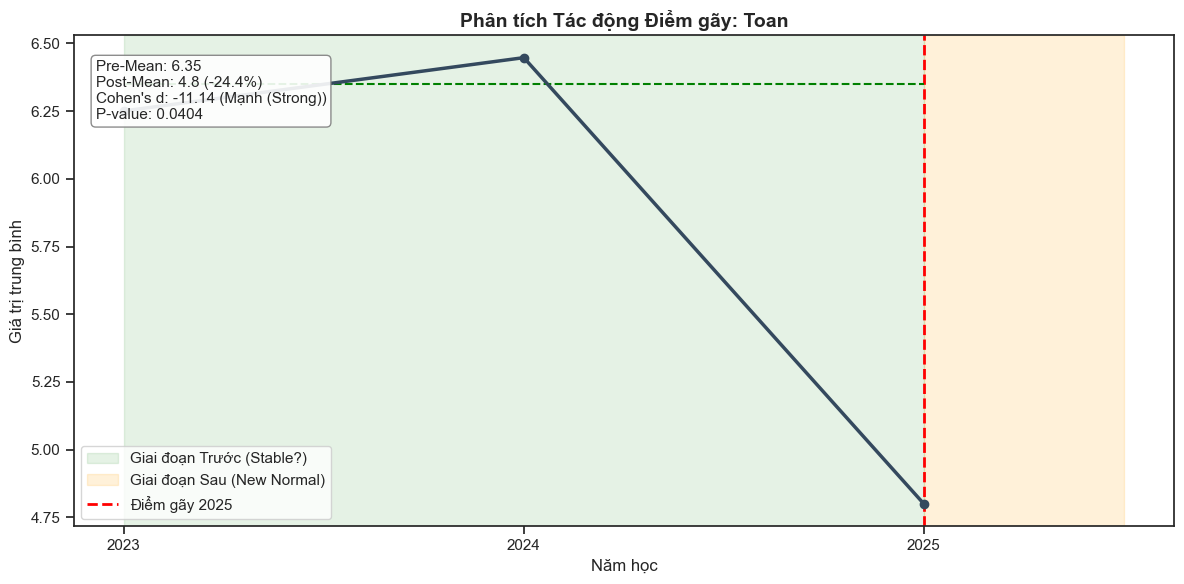

In [8]:
# --- CELL 5: PHÂN TÍCH SÂU VỀ ẢNH HƯỞNG CỦA ĐIỂM GÃY ---
analyzer = ChangePointAnalyzer(df_subjects, target_year=2025)


summary_df = analyzer.analyze_impact(all_results)

# Hiển thị bảng tổng hợp (Input định tính cho dự báo)
print("=== BẢNG TỔNG HỢP CHANGE POINT ===")
display(summary_df) 
# Kết quả sẽ có cột: magnitude (Mạnh/Vừa/Yếu), p_value (có ý nghĩa ko?), delta_pct (% thay đổi)

# 3.2 Vẽ biểu đồ minh họa cho môn có biến động mạnh nhất
if not summary_df.empty:
    # Lấy môn có Cohen's d lớn nhất
    top_change_series = summary_df.loc[summary_df['cohen_d'].abs().idxmax(), 'series_id']
    analyzer.plot_impact_visual(top_change_series)